# COVID in Santa Barbara County

Tracking how Santa Barbara County is faring with COVID-19.  The data comes from the [Santa Barbara County Public Health Department](http://www.countyofsb.org/phd/), which is updated every weekday; this page is updated weekly.

Hat tip to [Chris Lortie](https://cjlortie.github.io/SBC_Covid_Trends/) for the idea.

In [1]:
from math import log
import pandas as pd
import matplotlib.pyplot as plt

Load the data, which was previously scraped from the Department website using [this script](scrape.html).  The data is cumulative total confirmed cases broken down by date and by geographic area within the county.

In [2]:
raw_data = pd.read_csv("data/data.csv", parse_dates=["date"])
raw_data.head()

,area,cases,date
0,SOUTH COUNTY UNINCORPORATED AREA includes comm...,278,2020-11-25
1,CITY OF SANTA BARBARA and the unincorporated a...,1530,2020-11-25
2,CITY OF GOLETA,349,2020-11-25
3,COMMUNITY OF ISLA VISTA,517,2020-11-25
4,UNINCORPORATED AREA OF THE GOLETA VALLEY AND G...,282,2020-11-25


In [3]:
raw_data.date.min(), raw_data.date.max()

(Timestamp('2020-04-27 00:00:00'), Timestamp('2020-11-25 00:00:00'))

Sanity check: for each geographic area, the numbers of cases, being cumulative totals, should increase monotonically over time.  But this being the real world, in a few cases they don't.  Perhaps decreasing case numbers reflect corrections?

In [4]:
raw_data.assign(
    delta=raw_data.sort_values("date").groupby("area")["cases"].diff()
).query("delta < 0").sort_values("delta").head(10)

,area,cases,date,delta
1219,FEDERAL PRISON IN LOMPOC,984,2020-07-08,-10.0
1682,FEDERAL PRISON IN LOMPOC,893,2020-05-14,-3.0
912,SOUTH COUNTY UNINCORPORATED AREA includes comm...,166,2020-08-12,-2.0
583,FEDERAL PRISON IN LOMPOC,1024,2020-09-21,-2.0
332,CITY OF SANTA MARIA,4089,2020-10-20,-2.0
1815,CITY OF SANTA MARIA,139,2020-05-02,-2.0
1745,UNINCORPORATED AREA OF THE GOLETA VALLEY AND G...,15,2020-05-08,-1.0
1735,SANTA YNEZ VALLEY including the Cities of Solv...,7,2020-05-09,-1.0
1732,CITY OF GOLETA,10,2020-05-09,-1.0
1730,SOUTH COUNTY UNINCORPORATED AREA includes comm...,23,2020-05-09,-1.0


Ignoring that, for simplicity we consolidate geographic areas into two regions, north county and south county.  There's no firm dividing line, but below is the definition we use.  Notice that the Lompoc prison is excluded.  To smooth the data we downsample it to weeks instead of days. Because we're working with cumulative totals, we can do this simply by selecting all the Wednesdays (Wednesday because it avoids problems caused by missing data on weekends and holidays).

In [5]:
regions = {
    "south": [
        "SOUTH COUNTY UNINCORPORATED AREA includes communities of Montecito, Summerland and the City of Carpinteria",
        "CITY OF SANTA BARBARA and the unincorporated area of Mission Canyon",
        "CITY OF GOLETA",
        "COMMUNITY OF ISLA VISTA",
        "UNINCORPORATED AREA OF THE GOLETA VALLEY AND GAVIOTA",
        "SANTA YNEZ VALLEY including the Cities of Solvang & Buellton, and the communities of Santa Ynez, Los Alamos, Los Olivos and Ballard"
    ],
    "north": [
        "CITY OF LOMPOC and the communities of Mission Hills and Vandenberg Village",
        "CITY OF SANTA MARIA",
        "COMMUNITY OF ORCUTT",
        "UNINCORPORATED AREAS of Sisquoc, Casmalia, Garey, Cuyama, New Cuyama, and the City of Guadalupe"
    ],
    "other": [
        "FEDERAL PRISON IN LOMPOC",
        "People incarcerated at the Federal Prison in Lompoc",
        "Out of County"
    ],
}

region_map = {v: k for k, vlist in regions.items() for v in vlist}  # invert above mapping

base_data = (
    raw_data.assign(region=raw_data.apply(lambda row: region_map[row.area], axis=1))
    .query("region != 'other'")
    .groupby(["region", "date"])
    .sum()
    .query("date.dt.dayofweek == 2")
)

base_data.head()

cases
region date             
north  2020-04-29    271
       2020-05-06    311
       2020-05-13    348
       2020-05-20    404
       2020-05-27    486

The data will be easier to work with if north and south cases are split into separate columns.  And it's easiest to compute the weekly deltas at the same time.

In [6]:
base_data = base_data.assign(
    new_cases=base_data.sort_values("date").groupby("region")["cases"].diff()
).unstack(level=0)

base_data.head()

cases       new_cases      
region     north south     north south
date                                  
2020-04-29   271   104       NaN   NaN
2020-05-06   311   123      40.0  19.0
2020-05-13   348   127      37.0   4.0
2020-05-20   404   139      56.0  12.0
2020-05-27   486   159      82.0  20.0

## Cumulative total cases

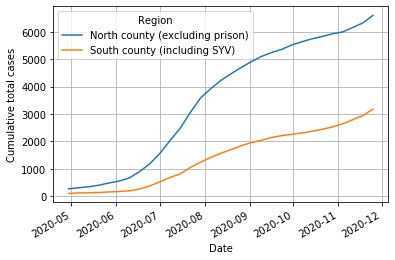

In [7]:
def legend():
    plt.legend(
        title="Region",
        labels=["North county (excluding prison)", "South county (including SYV)"]
    )

base_data.plot(y=[("cases", "north"), ("cases", "south")], grid=True)
plt.xlabel("Date")
plt.ylabel("Cumulative total cases")
legend()

## Weekly new cases

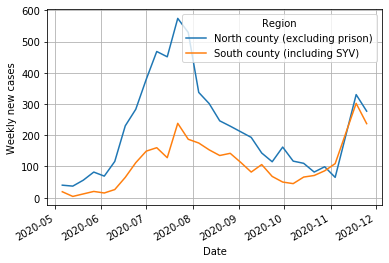

In [8]:
base_data.dropna().plot(y=[("new_cases", "north"), ("new_cases", "south")], grid=True)
plt.xlabel("Date")
plt.ylabel("Weekly new cases")
legend()

## Trajectory

Are we controlling the virus, or is it still spreading uncontrollably?  Following [Aatish Bhatia](https://aatishb.com/covidtrends/), we plot weekly new cases versus cumulative total cases.  The idea is that as long as the virus is spreading exponentially, the number of new cases arising is proportional to the total number of cases at any given time. When plotted, such growth appears as a straight line.  If/when the virus is controlled, the graph will plummet downward.

Note that time is implicit here.  The graphs for each region evolve left to right, but not necessarily at a uniform rate, and not necessarily at the same rate.

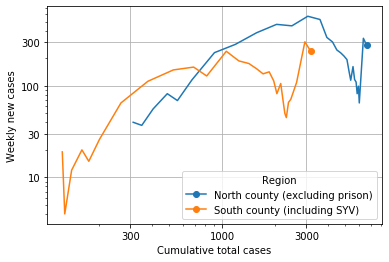

In [9]:
ax = plt.gca()
for region in ["north", "south"]:
    base_data.dropna().plot(
        ax=ax,
        x=("cases", region),
        y=[("new_cases", region)],
        style="-o",
        markevery=[-1],
        loglog=True,
        grid=True
    )
xticks = [300, 1000, 3000]  # default tick labels are lame
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
yticks = [10, 30, 100, 300]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
plt.xlabel("Cumulative total cases")
plt.ylabel("Weekly new cases")
legend()

## Growth rate

How fast is the virus spreading?  I.e., what growth rate does the general slope of the above graphs represent?  Looking at north county growth over the first 13 weeks for which we have data (i.e., when the cumulative number of cases in that region went from approximately 300 to approximately 3,000), we can compute from ${\it week}_1 \cdot {\it growth\_rate}^{12} = {\it week}_{13}$:

In [10]:
data = base_data.sort_values("date")
column = ("cases", "north")
growth_rate = (data.iloc[12][column]/data.iloc[0][column])**(1/12)
doubling_time = log(2)/log(growth_rate)  # weeks

print(f"Average growth rate each week: {int(round((growth_rate-1)*100))}%")
print("Doubling time in weeks:", round(doubling_time, 1))

Average growth rate each week: 22%
Doubling time in weeks: 3.4


Caveat: case counts are affected by the prevalence of testing and other factors.